In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
import math


import scipy 

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

import sys
sys.path.append("..")

from Ours import Ours
from FD import FD
from Functions import Quadratic

%load_ext autoreload
%autoreload 2

In [2]:
def create_ellipse(D, N, sample_point):
    scale = sample_point.T @ D @ sample_point
    X = np.random.normal(size=(2, N)) 
    X = X / jnp.linalg.norm(X, axis=0) * jnp.sqrt(scale)
    ellipse = jnp.linalg.inv(jnp.sqrt(D)) @ X
    return scale, ellipse

In [3]:
def get_mc_loss(F, x_0, num_runs, H=None):
    g_F = F.f1(x_0)
    if H is None:
        H = F.f2(x_0)
    def helper(grad_getter, jrandom_key):
        errs = []
        for _ in range(num_runs):
            jrandom_key, subkey = jrandom.split(jrandom_key)
            sgd = grad_getter.grad(F, x_0, subkey, H=H)[0]
            errs.append(float(jnp.linalg.norm(sgd - g_F)**2))
        errs = jnp.array(errs)
        return jnp.mean(errs), jnp.std(errs), jnp.percentile(errs, 25), jnp.percentile(errs, 75)
    return helper

# Create 2D plots

In [99]:
sig = 0.1

jrandom_key = jrandom.PRNGKey(0)

x_0 = jnp.ones(2)
res = []

a_range = jnp.logspace(-4, 4, 25)

num_MC = 50

for a in tqdm(a_range):
    D = jnp.array([[a, 0], [0, 1]])
    
    jrandom_key, subkey = jrandom.split(jrandom_key)
    
    F = Quadratic(1/2 * D, jnp.zeros(2), 0, sig=sig)
    
    l = get_mc_loss(F, x_0, num_MC)
    
    S_ours = Ours(sig, max_h=float("inf"))
    S_FD = FD(sig, is_central=False, h=float("inf"), use_H=True)

    res.append([l(S_ours, jrandom_key), l(S_FD, jrandom_key)])

    
res = jnp.array(res)



100%|███████████████████████████████████████████| 25/25 [00:12<00:00,  2.08it/s]


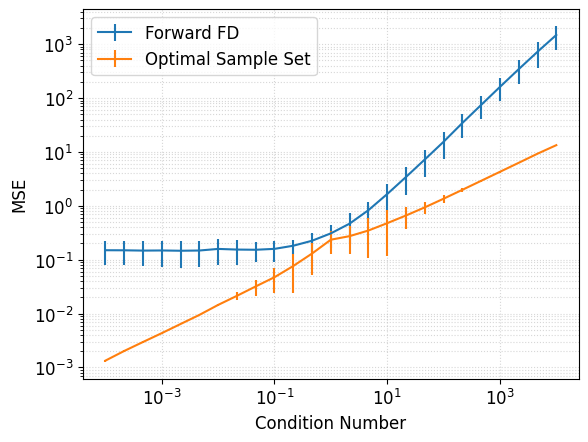

In [100]:
plt.errorbar(a_range, res[:, 1, 0], (res[:, 1, 3:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
plt.errorbar(a_range, res[:, 0, 0], (res[:, 0, 3:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Sample Set")
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)

plt.xlabel("Condition Number")
plt.ylabel("MSE")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_2d_Error.pdf".format(sig, num_MC))
plt.show()


In [91]:
help(plt.grid)

Help on function grid in module matplotlib.pyplot:

grid(visible=None, which='major', axis='both', **kwargs)
    Configure the grid lines.
    
    Parameters
    ----------
    visible : bool or None, optional
        Whether to show the grid lines.  If any *kwargs* are supplied, it
        is assumed you want the grid on and *visible* will be set to True.
    
        If *visible* is *None* and there are no *kwargs*, this toggles the
        visibility of the lines.
    
    which : {'major', 'minor', 'both'}, optional
        The grid lines to apply the changes on.
    
    axis : {'both', 'x', 'y'}, optional
        The axis to apply the changes on.
    
    **kwargs : `.Line2D` properties
        Define the line properties of the grid, e.g.::
    
            grid(color='r', linestyle='-', linewidth=2)
    
        Valid keyword arguments are:
    
        Properties:
        agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3

# Visualization

In [42]:
1 / 0.02

50.0

0.02
MC ours (DeviceArray(0.04011189, dtype=float64), DeviceArray(0.02003945, dtype=float64), DeviceArray(0.02609735, dtype=float64), DeviceArray(0.04919624, dtype=float64))
MC FD (DeviceArray(0.2914568, dtype=float64), DeviceArray(0.27620385, dtype=float64), DeviceArray(0.07590532, dtype=float64), DeviceArray(0.44621697, dtype=float64))


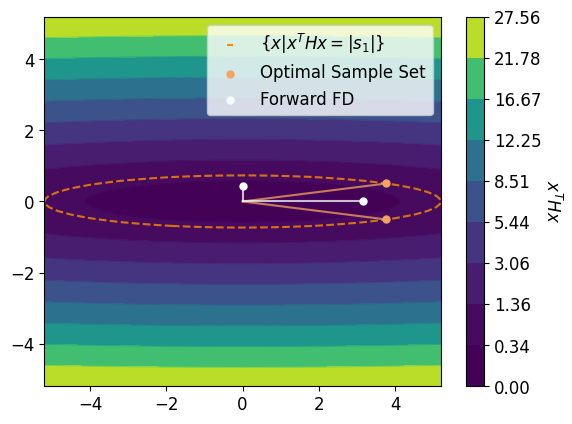

1
MC ours (DeviceArray(0.4997272, dtype=float64), DeviceArray(0.41178298, dtype=float64), DeviceArray(0.17086546, dtype=float64), DeviceArray(0.68536688, dtype=float64))
MC FD (DeviceArray(0.63607512, dtype=float64), DeviceArray(0.57050838, dtype=float64), DeviceArray(0.22632881, dtype=float64), DeviceArray(0.89681751, dtype=float64))


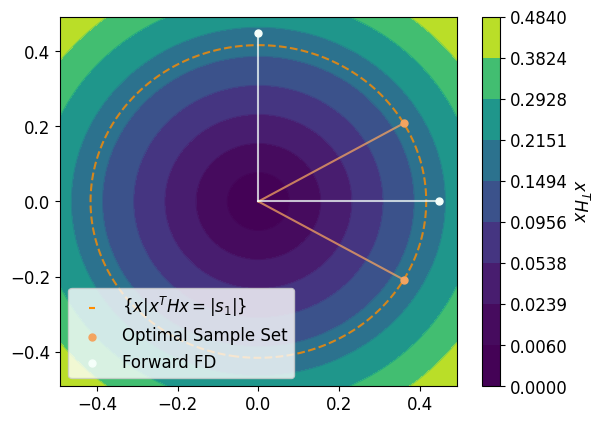

In [89]:
sig = 0.1
jrandom_key = jrandom.PRNGKey(0)

# l = loss_getter(2, 2, D, sig, coeff)
x_0 = jnp.zeros(2)
for a in [0.02, 1]: #jnp.logspace(-3, 1, 10):
    
    print(a)
    
    D = jnp.array([[a, 0], [0, 1]])
    
    jrandom_key, subkey = jrandom.split(jrandom_key)
    
    F = Quadratic(D, b=jnp.zeros(2), c=0, sig=sig)
    
    l = get_mc_loss(F, x_0, 50)
    
    
    S_ours_getter = Ours(sig, max_h=float('inf'))
    S_FD_getter = FD(sig, is_central=False, h=None, use_H=True)
    
    gd_ours, _, _, _, S_ours = S_ours_getter.grad(F, x_0, subkey, H=F.f2(x_0))
    gd_FD, _, _, _, S_FD = S_FD_getter.grad(F, x_0, subkey, H=F.f2(x_0))

    scale, ellipse = create_ellipse(D, 100, S_ours[:, 0])
        
    print("MC ours", l(S_ours_getter, subkey))
    print("MC FD", l(S_FD_getter, subkey))
    
#     plt.scatter(ellipse[0], ellipse[1])



    lim = max([jnp.max(jnp.abs(ellipse)), jnp.max(jnp.abs(S_FD))*1.1])

    
    X = jnp.linspace(-lim, lim, 100)
    X, Y = jnp.meshgrid(X, X)
    XY = np.vstack([X.ravel(), Y.ravel()])
    Z = jnp.diag(XY.T @ D @ XY).reshape(X.shape[0], Y.shape[0])


    levels = [lev**2 for lev in jnp.linspace(0, jnp.sqrt(lim**2 + a * lim**2), 10)]
    
#     plt.contour(X, Y, Z, levels)

    plt.scatter(S_ours[0], S_ours[1], marker="_", color="darkorange", zorder=3, s=25, label=r'$\{x \vert x^T H x = \vert s_1 \vert\}$')#"{x | x^T H x = |s_1|}")
    cp = plt.contourf(X, Y, Z, levels, antialiased=False)
    cp2 = plt.contour(X, Y, Z, levels, linewidths=0.75)

    clb = plt.colorbar(cp)
    clb.ax.set_ylabel('$x^T H x$', rotation="270", labelpad=15)
    
#     clb.ax.set_yticklabels(['{:.0f}'.format(x) for x in clb.ax.yaxis.get_ticklabels()])



    
    plt.scatter(S_ours[0], S_ours[1], color="sandybrown", zorder=3, s=25, label="Optimal Sample Set")
    plt.scatter(S_FD[0], S_FD[1], color="mintcream", zorder=3, s=25, label="Forward FD")
    
    plt.plot([0, S_ours[0, 0]], [0, S_ours[1, 0]], color="sandybrown", alpha=0.75, zorder=2)
    plt.plot([0, S_ours[0, 1]], [0, S_ours[1, 1]], color="sandybrown", alpha=0.75, zorder=2)

    
    plt.plot([0, S_FD[0, 0]], [0, S_FD[1, 0]], color="mintcream", alpha=0.75, zorder=2)
    plt.plot([0, S_FD[0, 1]], [0, S_FD[1, 1]], color="mintcream", alpha=0.75, zorder=2)
    
    plt.contour(X, Y, Z, levels=[scale], linestyles="dashed", alpha=0.8, colors=["darkorange"], zorder=1)




    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    
    plt.legend()


    plt.savefig("Figures/a_{}_sig_{}_2d.pdf".format(a, sig))
    plt.show()
    


In [83]:
help(plt.contour)

Help on function contour in module matplotlib.pyplot:

contour(*args, data=None, **kwargs)
    Plot contour lines.
    
    Call signature::
    
        contour([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == N`` is the number of columns in *Z* and
        ``len(Y) == M`` is the number of rows in *Z*.
    
        *X* and *Y* must both be ordered monotonically.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(N)``, ``Y = range(M)``.
    
    Z : (M, N) array-like
        The height values over which t

In [38]:
import matplotlib

# Create N-d plots

In [11]:
def create_errs(sig, dim, a_range, num_MC, H_sig, max_h, jrandom_key):

    x_0 = jnp.ones(dim)
    res = []
    S_size = []

    for a in tqdm(a_range):
        D = np.eye(dim)
        D[0, 0] = a
        D = jnp.array(D)


        F = Quadratic(1/2 * D, jnp.zeros(dim), 0, sig=sig)

#         jrandom_key, subkey = jrandom.split(jrandom_key)
#         H_noise = H_sig * jrandom.normal(subkey,shape=(dim, dim))
#         H_noise = (H_noise.T + H_noise)/2.
        H = F.f2(x_0) #+ H_noise

        l = get_mc_loss(F, x_0, num_MC, H=None)

        S_ours = Ours(sig, max_h=max_h)
        S_FD = FD(sig, is_central=False, h=max_h, use_H=True)

        jrandom_key, subkey = jrandom.split(jrandom_key)
        res.append([l(S_ours, subkey), l(S_FD, subkey)])
        S_size.append(S_ours.last_S_size)
    res = jnp.array(res)
    return res, S_size





In [ ]:
sig = 0.1

dim = 32

jrandom_key = jrandom.PRNGKey(1)

a_range = jnp.logspace(-4, 4, 25)

num_MC = 50

H_sig = 0
max_h = float('inf') #1e2
    
res, S_size = create_errs(sig, dim, a_range, num_MC, H_sig, max_h, jrandom_key)




 52%|██████████████████████▎                    | 13/25 [00:56<00:52,  4.41s/it]

In [ ]:
plt.errorbar(a_range, res[:, 1, 0], (res[:, 1, 3:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
plt.errorbar(a_range, res[:, 0, 0], (res[:, 0, 3:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)


plt.xlabel("Condition Number")
plt.ylabel("MSE")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_{}d_Error.jpeg".format(sig, num_MC, dim), dpi=500)

plt.show()



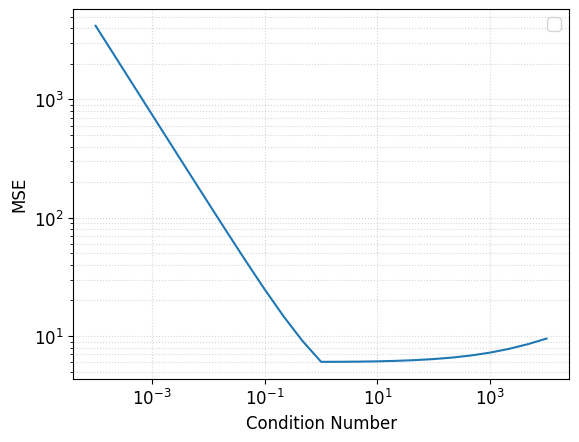

In [13]:
# plt.errorbar(a_range, res[:, 1, 0], (res[:, 1, 3:] - res[:, 1, 0].reshape(-1, 1)).T, label="Forward FD")
# plt.errorbar(a_range, res[:, 0, 0], (res[:, 0, 3:] - res[:, 0, 0].reshape(-1, 1)).T, label="Optimal Simplex Set")
plt.plot(a_range, S_size)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle=":", alpha=.5)


plt.xlabel("Condition Number")
plt.ylabel("Norm of optimal sample set")

plt.legend()

plt.savefig("Figures/sig_{}_num_{}_{}d_Error.jpeg".format(sig, num_MC, dim), dpi=500)

plt.show()


